In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

%load_ext tensorboard


In [14]:
# load the mnist dataset
dataset, info  = tfds.load("mnist", as_supervised=True, with_info=True)

In [15]:
mnist_train , mnist_test = dataset["train"],  dataset["test"]

tf.Tensor(4, shape=(), dtype=int64) <dtype: 'uint8'> (28, 28, 1)


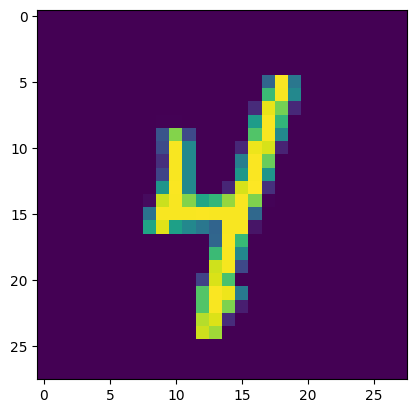

In [49]:
import matplotlib.pyplot as plt
for img, label in mnist_train:
    print(label, img.dtype, img.shape)
    plt.imshow(img)
    break

In [37]:
info.splits["train"].num_examples

60000

In [38]:
# define the distribution strategy

starategy = tf.distribute.MirroredStrategy()

print(f"Number of device : ", starategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of device :  1


In [40]:
num_train_examp = info.splits["train"].num_examples
num_test_examp = info.splits["test"].num_examples

num_test_examp, num_train_examp

(10000, 60000)

In [42]:
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * starategy.num_replicas_in_sync
BATCH_SIZE

64

In [43]:
# normalize the image
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    return image, label

In [46]:
train_data = mnist_train.map(scale).cache().shuffle(10000).batch(BATCH_SIZE)
test_data = mnist_test.map(scale).batch(BATCH_SIZE)

In [48]:
for image, label in train_data:
    print(image)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

2025-06-18 10:35:15.204563: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [82]:
with starategy.scope():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28,28,1)),
        tf.keras.layers.Conv2D(32,3,activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(10)
        
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics = ["accuracy"])

In [83]:
import os
checkpoint_dir = "./training"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-{epoch}.weights.h5")
checkpoint_prefix

'./training/ckpt-{epoch}.weights.h5'

In [84]:
# deacy function
def decay(epoch):
    if epoch < 3:
        return 1e-3
    if epoch >=3 and epoch <=7:
        return 1e-4
    else:
        return 1e-5
    
    
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(        epoch + 1, model.optimizer.learning_rate.numpy()))

In [85]:
## define callback
callbacke = [
    tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
    
]

In [86]:
# Train and evaluate



In [87]:
epochs =12

model.fit(train_data, epochs=epochs, callbacks=callbacke, validation_data=test_data)

Epoch 1/12


W0000 00:00:1750226737.708656   36750 auto_shard.cc:558] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2025-06-18 11:35:37.733115: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8780 - loss: 0.4174

W0000 00:00:1750226742.391287   36750 auto_shard.cc:558] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2025-06-18 11:35:42.430187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Learning rate for epoch 1 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8784 - loss: 0.4158 - val_accuracy: 0.9789 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 2/12
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9783 - loss: 0.0755
Learning rate for epoch 2 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9783 - loss: 0.0755 - val_accuracy: 0.9775 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 3/12
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9851 - loss: 0.0510
Learning rate for epoch 3 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9851 - loss: 0.0509 - val_accuracy: 0.9820 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 4/12
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9911 - loss: 0.0314
Learning rate for epoch 4 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9911 - loss: 0.0314 - val_accuracy: 0.9866 - val_loss: 0.04

2025-06-18 11:35:56.853004: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9923 - loss: 0.0277
Learning rate for epoch 5 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9923 - loss: 0.0277 - val_accuracy: 0.9864 - val_loss: 0.0406 - learning_rate: 1.0000e-04
Epoch 6/12
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9939 - loss: 0.0236
Learning rate for epoch 6 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9939 - loss: 0.0236 - val_accuracy: 0.9866 - val_loss: 0.0396 - learning_rate: 1.0000e-04
Epoch 7/12
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.0215

2025-06-18 11:36:10.866664: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Learning rate for epoch 7 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9946 - loss: 0.0215 - val_accuracy: 0.9867 - val_loss: 0.0390 - learning_rate: 1.0000e-04
Epoch 8/12
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9945 - loss: 0.0208
Learning rate for epoch 8 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9945 - loss: 0.0208 - val_accuracy: 0.9862 - val_loss: 0.0395 - learning_rate: 1.0000e-04
Epoch 9/12
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9954 - loss: 0.0193
Learning rate for epoch 9 is 9.999999747378752e-06
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9955 - loss: 0.0192 - val_accuracy: 0.9864 - val_loss: 0.0388 - learning_rate: 1.0000e-05
Epoch 10/12
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0182
Learning rate for epoch 10 is 9.999999747378752e-06
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9959 - loss: 0.0182 - val_accuracy: 0.9865 - 

In [91]:
ls {checkpoint_dir}

ckpt-1.weights.h5   ckpt-12.weights.h5  ckpt-4.weights.h5   ckpt-7.weights.h5
ckpt-10.weights.h5  ckpt-2.weights.h5   ckpt-5.weights.h5   ckpt-8.weights.h5
ckpt-11.weights.h5  ckpt-3.weights.h5   ckpt-6.weights.h5   ckpt-9.weights.h5


In [96]:
model.load_weights(f"{checkpoint_dir}/ckpt-9.weights.h5")

In [97]:
model.evaluate(test_data)

 60/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0407

W0000 00:00:1750227765.494058   36750 auto_shard.cc:558] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2025-06-18 11:52:45.525022: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0398


[0.0388031080365181, 0.9864000082015991]

In [100]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 21730), started 0:00:17 ago. (Use '!kill 21730' to kill it.)

In [101]:
model.save("my_model.keras")

In [102]:
new_model = tf.keras.models.load_model("my_model.keras")

In [103]:
new_model.evaluate(test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0398


[0.0388031080365181, 0.9864000082015991]